**写在前面：**本节内容是 [Datawhale四月组队学习 - 集成学习（中）- CH3-投票法思路、原理、案例部分 -【Task7 投票法的原理和案例分析】](https://github.com/datawhalechina/team-learning-data-mining/tree/master/EnsembleLearning) 的学习笔记，对应notebook的第3节的投票法部分，学习周期3天

## 导入库和数据

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

from matplotlib import pyplot

In [9]:
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=2)
    # summarize the dataset
    return X,y

In [40]:
# get a voting ensemble of models
def get_voting():
    # define the base models
    models = list()
    models.append(('knn1', KNeighborsClassifier(n_neighbors=1)))
    models.append(('knn3', KNeighborsClassifier(n_neighbors=3)))
    models.append(('knn5', KNeighborsClassifier(n_neighbors=5)))
    models.append(('knn7', KNeighborsClassifier(n_neighbors=7)))
    models.append(('knn9', KNeighborsClassifier(n_neighbors=9)))
    # define the voting ensemble
    ensemble = VotingClassifier(estimators=models, voting='hard', verbose=False)
    return ensemble

In [32]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['knn1'] = KNeighborsClassifier(n_neighbors=1)
    models['knn3'] = KNeighborsClassifier(n_neighbors=3)
    models['knn5'] = KNeighborsClassifier(n_neighbors=5)
    models['knn7'] = KNeighborsClassifier(n_neighbors=7)
    models['knn9'] = KNeighborsClassifier(n_neighbors=9)
    models['hard_voting'] = get_voting()
    return models

In [45]:
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=1, error_score='raise')
    return scores

## Day1 投票法(voting)的理论知识
**参考资料：**
- [集成学习的不二法门bagging、boosting和三大法宝<结合策略>平均法，投票法和学习法（stacking）](https://www.cnblogs.com/wqbin/p/11634111.html)
- [深入了解模型融合Ensemble(深度+代码)](https://zhuanlan.zhihu.com/p/69415215)
- [「融合」机器学习模型：一种提升预测能力的方法](https://zhuanlan.zhihu.com/p/33589222)

&emsp;&emsp;投票法遵从少数服从多数原则，通过多个模型的集成降低方差，从而提升模型鲁棒性。  

1. 从**投票机制**主要分为三种：
    - 相对多数投票法：是少数服从多数，将预测结果中票数最高的分类类别。如果不止一个类别获得最高票，则随机选择一个作为最终类别。
    - 绝对多数投票法：不光要求获得最高票，还要求票过半数。
    - 加权投票法：将每个弱学习器的分类票数乘以一个权重（如：1/loss），最终将各个类别的加权票数求和，最大的值对应的类别为最终类别。

2. 投票法在**回归与分类任务**上均可使用：
    - 归任务：是所有模型预测结果的平均值。
    - 分类任务：是所有模型中出现最多的预测结果

3. 分类投票法从**投票方式**又可以被划分：  
    - 硬投票：所有投票结果最多出现的类。
    - 软投票：所有投票结果中概率加和最大的类。

&emsp;&emsp;此外，在[深入了解模型融合Ensemble(深度+代码)](https://zhuanlan.zhihu.com/p/69415215)里提到，弱相关的模型进行投票能对模型性能进行更大的提升，我从感觉上是认同这种说法的。同时在[「融合」机器学习模型：一种提升预测能力的方法](https://zhuanlan.zhihu.com/p/33589222)里提到“寻找优秀的子模型”，即准而不同的模型，这样作为一个整体才能起到互补作用；另外也给出了筛选子模型的思路，即设法给予“优秀的子模型”更大的权重，可以以子模型的准确率等代表模型性能的指标来分配权重。对于模型的“不同”，我认为一方面可以是使用模型的思想不同，如线性模型、树模型、聚类模型等等；另外还可以从训练的数据上的不同使得模型不同，我的想法是分别原始特征和特征工程生成的特征训练模型，这样得到的模型就有理由相信它们是不同的。

## Day2 投票法的相关工具

### sklearn
**VotingClassifier**重要参数:
- `estimators`:传入模型序列
- `voting`:投票方式，可选soft和hard，对应软投票和硬投票
- `weights`:权重序列
- `verbose`:打印拟合花费的时间

**VotingRegressor**重要参数：
- `estimators`:传入模型序列
- `weights`:权重序列
- `verbose`:打印拟合花费的时间

## Day3

### 投票法的实际使用

>knn1 0.873 (0.030)
>knn3 0.889 (0.038)
>knn5 0.895 (0.031)
>knn7 0.899 (0.035)
>knn9 0.900 (0.033)
>hard_voting 0.902 (0.034)


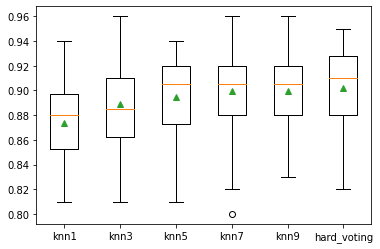

In [46]:
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()